In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
(X, y), (test_images, test_labels) = fashion_mnist.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(X, y, test_size=0.1, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


Download the fashion-MNIST dataset and plot 1 sample image for each class

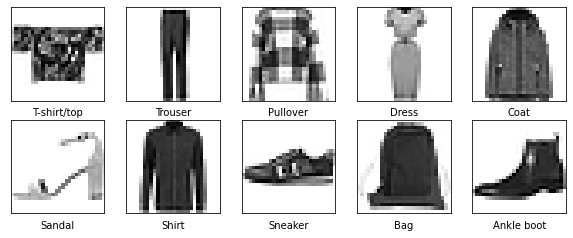

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
k=len(class_names)
images_plot,count=[],0
for i in range(len(train_images)):
  if(count>=k): break
  if(count==train_labels[i]):
    images_plot.append(train_images[i])
    count+=1

plt.figure(figsize=(10,10))
for i in range(10):
     plt.subplot(5,5,i+1)
     plt.xticks([])
     plt.yticks([])
     plt.imshow(images_plot[i], cmap=plt.cm.binary)
     plt.xlabel(class_names[i])


Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.



In [5]:
#flat the input
image_size=28*28
train_images_X=np.zeros(shape=(len(train_images),image_size),dtype='float32')  #60000x728
test_images_X=np.zeros(shape=(len(test_images),image_size),dtype='float32')    #10000x728
val_images_X=np.zeros(shape=(len(val_images),image_size),dtype='float32') 

for i in range(len(train_images)):
  train_images_X[i]=train_images[i].flatten()/255

for i in range(len(test_images)):
  test_images_X[i]=test_images[i].flatten()/255

for i in range(len(val_images)):
  val_images_X[i]=val_images[i].flatten()/255

def one_hot(i):
  y=np.zeros((10,1))
  y[i]=1
  return y

In [6]:
def relu(x):
    return np.maximum(0,x)

def tanh(x):
    return np.tanh(x)

def sigmoid(x): 
   return 1./(1.+np.exp(-x))

def derivative_relu(x):
  return 1*(x>0) 

def softmax(x):
  x=x-max(x)
  return np.exp(x)/np.sum(np.exp(x))

def derivative_sigmoid(x):
  return sigmoid(x)*(np.ones_like(x)-sigmoid(x))

def derivative_tanh(x):
    return (1 - (np.tanh(x)**2))


def cross_entropy(true_output,predicted_output):
     return -1.0*np.sum(true_output*np.log(predicted_output+1e-9))
  
def l2loss(parameters,lamda):
  l2loss=0
  for i in range(1,len(parameters)//2+1):
    l2loss+=(lamda/2)*np.sum(np.linalg.norm(parameters['W'+str(i)])**2)
  return l2loss

In [7]:
def activation_function(funct,x,derivative=False):
  if derivative==True:
    if funct=="sigmoid":
      return derivative_sigmoid(x)
    if funct=="relu":
      return derivative_relu(x)
    if funct=="tanh":
      return derivative_tanh(x)
  
  else:
    if funct=="sigmoid":
      return sigmoid(x)
    if funct=="relu":
      return relu(x)
    if funct=="tanh":
      return tanh(x)
  

In [8]:
def validation_loss(X,y,params,lamda):
  cnt,loss=0,0
  for i in range(len(X)):
    predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,params,hidden_layer_size,k,X[i],function)
    loss+=cross_entropy(one_hot(y[i]),predicted_y)
    if(np.argmax(predicted_y)==y[i]):
      cnt+=1
  loss+=l2loss(params,lamda)
  print('Validation loss:', loss/len(X))
  print('Validation accuracy:',cnt/len(X)*100)

In [9]:
def init(n_in, n_out,initialization):
    if(initialization=='normal'):
      return np.random.default_rng().uniform(low=-0.69,high=0.69,size=(n_in,n_out))
    if(initialization=='xavier'):
      variance = 2.0 / (n_in + n_out)
      std_dev = np.sqrt(variance)
      weights = np.random.rand(n_in, n_out)
      return weights/std_dev
    if(initialization=='zero'):
      return np.zeros((n_in,n_out))


def initialize_parameters(number_of_neurons,number_hidden_layers,k,layers,initialization):
  parameters={}
  parameters['W'+str(1)]=init(layers[0],image_size,initialization)
  parameters['b'+str(1)]=init(layers[0],1,initialization)
  for i in range(1,number_hidden_layers):
    parameters['W'+str(i+1)]=init(layers[i],layers[i-1],initialization)
    parameters['b'+str(i+1)]=init(layers[i],1,initialization)
  parameters['W'+str(number_hidden_layers+1)]=init(k,layers[-1],initialization)
  parameters['b'+str(number_hidden_layers+1)]=init(k,1,initialization)
  return parameters


In [10]:
def feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,data,function):
  activation={}
  pre_activation={}

  activation['h0']=data.reshape(784,1)
  for i in range(1,number_hidden_layers+1):
    a=np.add(parameters['b'+str(i)],np.matmul(parameters['W'+str(i)],activation['h'+str(i-1)]))
    h=activation_function(function,a)
    #print(h.shape)
    #h=sigmoid(a)
    pre_activation['a'+str(i)]=a
    activation['h'+str(i)]=h
  
  a=np.add(parameters['b'+str(number_hidden_layers+1)],np.matmul(parameters['W'+str(number_hidden_layers+1)],activation['h'+str(number_hidden_layers)]))
  h=softmax(a)
  pre_activation['a'+str(number_hidden_layers+1)]=a
  activation['h'+str(number_hidden_layers+1)]=h
  
  return h,activation,pre_activation



In [11]:
#h:: activation a=:preactivation
def back_propogation(parameters,activation,pre_activation,X,y,number_hidden_layers,predicted_y,k,lamda,function):

  gradient_parameters,gradient_activation,gradient_preactivation={},{},{}

  #compute output gradient
  e_y=np.zeros((k,1))
  e_y[y][0]=1
  gradient_preactivation['a'+str(number_hidden_layers+1)]=-(e_y-predicted_y)

  for t in range(number_hidden_layers+1,0,-1):
    #compute gradients w.r.t parameters
    gradient_parameters['W'+str(t)]=np.matmul(gradient_preactivation['a'+str(t)],activation['h'+str(t-1)].T) 
    gradient_parameters['b'+str(t)]=gradient_preactivation['a'+str(t)]
    #print(t,gradient_parameters['W'+str(t)])
    if(t==1):break
    #compute gradients w.r.t layers below
    gradient_activation['h'+str(t-1)]=np.matmul(parameters['W'+str(t)].T,gradient_preactivation['a'+str(t)])

    #compute gradients w.r.t preactivation layer
    gradient_preactivation['a'+str(t-1)]=np.multiply(gradient_activation['h'+str(t-1)],activation_function(function,pre_activation['a'+str(t-1)],True))
  #print(pre_activation)
  return gradient_parameters

In [12]:
def update_parameters(parameters,gradient_change,learning_rate):
  for i in range(1,len(parameters)//2+1):
    parameters['W'+str(i)]=parameters['W'+str(i)]-learning_rate*gradient_change['W'+str(i)]
    parameters['b'+str(i)]=parameters['b'+str(i)]-learning_rate*gradient_change['b'+str(i)]
  return parameters

def update_parameters_momentum(parameters,gradient_change,prior_updates,learning_rate,beta):
  for i in range(1,len(parameters)//2+1):
    prior_updates['W'+str(i)]=beta*prior_updates['W'+str(i)]+gradient_change['W'+str(i)]
    parameters['W'+str(i)]=parameters['W'+str(i)]-learning_rate*prior_updates['W'+str(i)]

    prior_updates['b'+str(i)]=beta*prior_updates['b'+str(i)]+gradient_change['b'+str(i)]
    parameters['b'+str(i)]=parameters['b'+str(i)]-learning_rate*prior_updates['b'+str(i)]
  return parameters,prior_updates

def update_parameters_rmsprop(parameters,gradient_change,prior_updates,learning_rate,beta):
  epsilon=1e-9
  for i in range(1,len(parameters)//2+1):
    prior_updates['W'+str(i)]=beta*prior_updates['W'+str(i)]+(1-beta)*(gradient_change['W'+str(i)])**2
    parameters['W'+str(i)]=parameters['W'+str(i)]-gradient_change['W'+str(i)]*(learning_rate/np.sqrt(prior_updates['W'+str(i)]+epsilon))

    prior_updates['b'+str(i)]=beta*prior_updates['b'+str(i)]+(1-beta)*(gradient_change['b'+str(i)])**2
    parameters['b'+str(i)]=parameters['b'+str(i)]-gradient_change['b'+str(i)]*(learning_rate/np.sqrt(prior_updates['b'+str(i)]+epsilon))
  return parameters,prior_updates





In [13]:
def gradient_descent_nag(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,X,y,k,optimizer,learning_rate,beta,layers,initialization,lamda,function):
  parameters=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,initialization)
  prior_updates=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')
  updates=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')
  temp=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')
  for epoch in range(max_epochs):
    loss,cnt=0,0
    for it in range(1,len(parameters)//2+1):
      updates['W'+str(it)]=prior_updates['W'+str(it)]*beta
      updates['b'+str(it)]=prior_updates['b'+str(it)]*beta
    
    for it in range(1,len(parameters)//2+1):
      temp['W'+str(it)]=parameters['W'+str(it)]-updates['W'+str(it)]
      temp['b'+str(it)]=parameters['b'+str(it)]-updates['b'+str(it)]
    
    for i in range(len(X)):
      predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,temp,hidden_layer_size,k,X[i],function)
      loss+=cross_entropy(one_hot(train_labels[i]),predicted_y)
      gradient_parameters=back_propogation(temp,activation,pre_activation,X[i],y[i],number_hidden_layers,predicted_y,k,lamda,function)
      
      if(cnt==0):
        gradient_change=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')
      else:
        for iter in range(1,len(parameters)//2+1):
          gradient_change['W'+str(iter)]+=gradient_parameters['W'+str(iter)]
          gradient_change['b'+str(iter)]+=gradient_parameters['b'+str(iter)]
      cnt+=1

      if(cnt%batch_size==0 or i==len(X)-1):
        if(lamda!=0):
          for it in range(1,len(parameters)//2+1):
            gradient_change['W'+str(it)]+=np.dot(lamda,parameters['W'+str(it)])

        t=cnt if (i==len(X)-1) else batch_size
        for it in range(1,len(parameters)//2+1):
          gradient_change['W'+str(it)]=gradient_change['W'+str(it)]/t
          gradient_change['b'+str(it)]=gradient_change['b'+str(it)]/t
        cnt=0

        #update rule
        for it in range(1,len(parameters)//2+1):
          updates['W'+str(it)]=beta*prior_updates['W'+str(it)]+learning_rate*gradient_change['W'+str(it)]
          parameters['W'+str(it)]=parameters['W'+str(it)]-updates['W'+str(it)]
          temp['W'+str(it)]=parameters['W'+str(it)]
          prior_updates['W'+str(it)]=updates['W'+str(it)]

          updates['b'+str(it)]=beta*prior_updates['b'+str(it)]+learning_rate*gradient_change['b'+str(it)]
          parameters['b'+str(it)]=parameters['b'+str(it)]-updates['b'+str(it)]
          temp['b'+str(it)]=parameters['b'+str(it)]
          prior_updates['b'+str(it)]=updates['b'+str(it)]
    l2regularizedloss=l2loss(parameters,lamda)
    loss+=l2regularizedloss
    print(epoch,loss/len(X))
    validation_loss(val_images_X,val_labels,parameters,lamda)
    
  return parameters


In [14]:

def gradient_descent_sgd(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,X,y,k,optimizer,learning_rate,beta,layers,initialization,lamda,function):
  parameters=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,initialization)
  for epoch in range(max_epochs):
    loss=0
    cnt=0
    for i in range(len(X)):
      predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,X[i],function)
      loss+=cross_entropy(one_hot(train_labels[i]),predicted_y)
      gradient_parameters=back_propogation(parameters,activation,pre_activation,X[i],y[i],number_hidden_layers,predicted_y,k,lamda,function)
    
      if(cnt==0):
        gradient_change={}
        gradient_change=gradient_parameters.copy()

      else:
        for iter in range(1,len(parameters)//2+1):
          gradient_change['W'+str(iter)]+=gradient_parameters['W'+str(iter)]
          gradient_change['b'+str(iter)]+=gradient_parameters['b'+str(iter)]
      cnt+=1
      
      if(cnt%batch_size==0 or i==len(X)-1):
        t=cnt if (i==len(X)-1) else batch_size

        if(lamda!=0):
           for it in range(1,len(parameters)//2+1):
             gradient_change['W'+str(it)]+=np.dot(lamda,parameters['W'+str(it)])

        for it in range(1,len(parameters)//2+1):
          gradient_change['W'+str(it)]=gradient_change['W'+str(it)]/t
          gradient_change['b'+str(it)]=gradient_change['b'+str(it)]/t
        cnt=0
        parameters=update_parameters(parameters,gradient_change,learning_rate)
    l2regularizedloss=l2loss(parameters,lamda)
    loss+=l2regularizedloss
    print(epoch,loss/len(X))
    validation_loss(val_images_X,val_labels,parameters,lamda)
  return parameters


In [15]:
def gradient_descent_momentum(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,X,y,k,optimizer,learning_rate,beta,layers,initialization,lamda,function):
  parameters=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,initialization)
  for epoch in range(max_epochs):
    loss=0
    cnt=0
    for i in range(len(X)):
      predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,X[i],function)
      #print(activation['h4'])
      
      loss+=cross_entropy(one_hot(train_labels[i]),predicted_y)
      gradient_parameters=back_propogation(parameters,activation,pre_activation,X[i],y[i],number_hidden_layers,predicted_y,k,lamda,function)
      if( epoch==0 and i==0):
        #initialize with zero
        prior_updates=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')

      if(cnt==0):
        gradient_change={}
        gradient_change=gradient_parameters.copy()

      else:
        for iter in range(1,len(parameters)//2+1):
          gradient_change['W'+str(iter)]+=gradient_parameters['W'+str(iter)]
          gradient_change['b'+str(iter)]+=gradient_parameters['b'+str(iter)]
      cnt+=1
      
      if(cnt%batch_size==0 or i==len(X)-1):
        t=cnt if (i==len(X)-1) else batch_size

        
        if(lamda!=0):
          for it in range(1,len(parameters)//2+1):
            gradient_change['W'+str(it)]+=np.dot(lamda,parameters['W'+str(it)])

        for it in range(1,len(parameters)//2+1):
          gradient_change['W'+str(it)]=gradient_change['W'+str(it)]/t
          gradient_change['b'+str(it)]=gradient_change['b'+str(it)]/t
        cnt=0
        parameters,prior_updates=update_parameters_momentum(parameters,gradient_change,prior_updates,learning_rate,beta)
    l2regularizedloss=l2loss(parameters,lamda)
    loss+=l2regularizedloss
    print(epoch,loss/len(X))
    validation_loss(val_images_X,val_labels,parameters,lamda)
    
  return parameters


In [16]:

def gradient_descent_rmsprop(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,X,y,k,optimizer,learning_rate,beta,layers,initialization,lamda,function):
  parameters=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,initialization)
  for epoch in range(max_epochs):
    loss=0
    cnt=0
    for i in range(len(X)):
      predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,X[i],function)
      #print(activation['h4'])
      
      loss+=cross_entropy(one_hot(train_labels[i]),predicted_y)
      gradient_parameters=back_propogation(parameters,activation,pre_activation,X[i],y[i],number_hidden_layers,predicted_y,k,lamda,function)
      if( epoch==0 and i==0):
        #initialize with zero
        prior_updates=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')

      if(cnt==0):
        gradient_change={}
        gradient_change=gradient_parameters.copy()

      else:
        for iter in range(1,len(parameters)//2+1):
          gradient_change['W'+str(iter)]+=gradient_parameters['W'+str(iter)]
          gradient_change['b'+str(iter)]+=gradient_parameters['b'+str(iter)]
      cnt+=1
      
      if(cnt%batch_size==0 or i==len(X)-1):
        t=cnt if (i==len(X)-1) else batch_size

        
        if(lamda!=0):
          for it in range(1,len(parameters)//2+1):
            gradient_change['W'+str(it)]+=np.dot(lamda,parameters['W'+str(it)])

        for it in range(1,len(parameters)//2+1):
          gradient_change['W'+str(it)]=gradient_change['W'+str(it)]/t
          gradient_change['b'+str(it)]=gradient_change['b'+str(it)]/t
        cnt=0
        parameters,prior_updates=update_parameters_rmsprop(parameters,gradient_change,prior_updates,learning_rate,beta)
    l2regularizedloss=l2loss(parameters,lamda)
    loss+=l2regularizedloss
    print(epoch,loss/len(X))
    validation_loss(val_images_X,val_labels,parameters,lamda)
  return parameters


In [17]:
def gradient_descent_adam(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,X,y,k,optimizer,learning_rate,beta,layers,initialization,lamda,function):
  beta1=0.9
  beta2=0.99
  parameters=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,initialization)
  momentum=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')
  momentum_hat=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')
  update=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')
  update_hat=initialize_parameters(hidden_layer_size,number_hidden_layers,k,layers,'zero')

  for epoch in range(max_epochs):
    loss=0
    cnt=0
    epsilon=1e-10
    for i in range(len(X)):
      predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,X[i],function)
      loss+=cross_entropy(one_hot(train_labels[i]),predicted_y)
      gradient_parameters=back_propogation(parameters,activation,pre_activation,X[i],y[i],number_hidden_layers,predicted_y,k,lamda,function)
      if(cnt==0):
        gradient_change={}
        gradient_change=gradient_parameters.copy()

      else:
        for iter in range(1,len(parameters)//2+1):
          gradient_change['W'+str(iter)]+=gradient_parameters['W'+str(iter)]
          gradient_change['b'+str(iter)]+=gradient_parameters['b'+str(iter)]
      cnt+=1
      
      if(cnt%batch_size==0 or i==len(X)-1):

        if(lamda!=0):
          for it in range(1,len(parameters)//2+1):
            gradient_change['W'+str(it)]+=np.dot(lamda,parameters['W'+str(it)])

        t=cnt if (i==len(X)-1) else batch_size
        for it in range(1,len(parameters)//2+1):
          gradient_change['W'+str(it)]=gradient_change['W'+str(it)]/t
          gradient_change['b'+str(it)]=gradient_change['b'+str(it)]/t
        
        cnt=0
        for it in range(1,len(parameters)//2+1):
          momentum['W'+str(it)]=beta1*momentum['W'+str(it)]+(1-beta1)*gradient_change['W'+str(it)]
          momentum['b'+str(it)]=beta1*momentum['b'+str(it)]+(1-beta1)*gradient_change['b'+str(it)]
          momentum_hat['W'+str(it)]=momentum['W'+str(it)]/(1-beta1**(epoch+1))
          momentum_hat['b'+str(it)]=momentum['b'+str(it)]/(1-beta1**(epoch+1))

        for it in range(1,len(parameters)//2+1):
          update['W'+str(it)]=beta2*update['W'+str(it)]+(1-beta2)*gradient_change['W'+str(it)]**2
          update['b'+str(it)]=beta2*update['b'+str(it)]+(1-beta2)*gradient_change['b'+str(it)]**2
          update_hat['W'+str(it)]=update['W'+str(it)]/(1-beta2**(epoch+1))
          update_hat['b'+str(it)]=update['b'+str(it)]/(1-beta2**(epoch+1))

        if(optimizer=='adam'):
          for it in range(1,len(parameters)//2+1):
            parameters['W'+str(it)]=parameters['W'+str(it)]-(learning_rate*momentum_hat['W'+str(it)]/np.sqrt(update_hat['W'+str(it)]+epsilon))
            parameters['b'+str(it)]=parameters['b'+str(it)]-(learning_rate*momentum_hat['b'+str(it)]/np.sqrt(update_hat['b'+str(it)]+epsilon))
        else:
          for it in range(1,len(parameters)//2+1):
            parameters['W'+str(it)]=parameters['W'+str(it)]-(learning_rate/np.sqrt(update_hat['W'+str(it)]+epsilon))*(beta1*momentum_hat['W'+str(it)]+(1-beta1)*gradient_change['W'+str(it)]/(1-beta1**(epoch+1)))
            parameters['b'+str(it)]=parameters['b'+str(it)]-(learning_rate/np.sqrt(update_hat['b'+str(it)]+epsilon))*(beta1*momentum_hat['b'+str(it)]+(1-beta1)*gradient_change['b'+str(it)]/(1-beta1**(epoch+1)))
    
    l2regularizedloss=l2loss(parameters,lamda)
    loss+=l2regularizedloss
    print(epoch,loss/len(X))
    validation_loss(val_images_X,val_labels,parameters,lamda)
   
  return parameters


In [18]:
layers=[32,32,32,64]

In [ ]:
number_hidden_layers=4
hidden_layer_size=32
batch_size=32
max_epochs=3
k=10
optimizer='nag'
function='tanh'
learning_rate=0.01
beta=0.9
lamda=0.5
initialization='normal'
params=gradient_descent_nag(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,train_images_X,train_labels,k,optimizer,learning_rate,beta,layers,initialization,lamda,function)

In [21]:
def accuracy(X,y,params):
  cnt=0
  for i in range(len(X)):
    predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,params,hidden_layer_size,k,X[i],function)
    if(np.argmax(predicted_y)==y[i]):
      cnt+=1
  print(cnt/len(X)*100)

In [ ]:
accuracy(train_images_X,train_labels,params)

In [22]:
accuracy(test_images_X,test_labels,params)

78.86
